<a href="https://colab.research.google.com/github/necoarcreator/samplesML/blob/main/SimsonsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import torch
import numpy as np

import PIL

In [88]:
import pickle

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler


from matplotlib import colors, pyplot as plt
%matplotlib inline

In [89]:
#don't forget to set GPU as a device!
#click Runtime -> change Runtime -> server's GPU

In [90]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [91]:
#upload the dataset on drive -> click on folders here ->  open drive -> copy path to simpsons4.zip to "unzip" operation

In [92]:
!unzip -q /content/drive/MyDrive/simpsons4Copy.zip -d dataset

replace dataset/characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [93]:
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to the size of 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [94]:
#copying paths as masks in order to simplify operations with them
TRAIN_DIR = Path('/content/dataset/train/simpsons_dataset')
TEST_DIR = Path('/content/dataset/testset/testset')
#saving images as variables
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [95]:
train_val_files[5:15]

[PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0006.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0007.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0008.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0009.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0010.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0011.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0012.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0013.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/abraham_grampa_simpson/pic_0014.jpg')]

In [96]:
train_val_files[1500:1510]

[PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0193.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0194.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0195.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0196.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0197.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0198.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0199.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0200.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0201.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/apu_nahasapeemapetilon/pic_0202.jpg')]

In [97]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [98]:
class SimpsonsDataset(Dataset):

    #Dataset with pictures, which loads them from folders,
    #scales and turns into torch tensors

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)


        self.transform =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # converts images into PyTorch tensors and normalize

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')

        if self.mode == 'test':
            x = self.transform(x)
            return x

        elif self.mode == 'train':
            # in case mode == 'train' the transformation and augmentations will
            # take place directly in the fit_epoch() function for each batch
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = self.transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [99]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    #Imshow for tensors
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize = 10)
    plt_ax.grid(False)

In [100]:
val_dataset = SimpsonsDataset(val_files, mode='val')

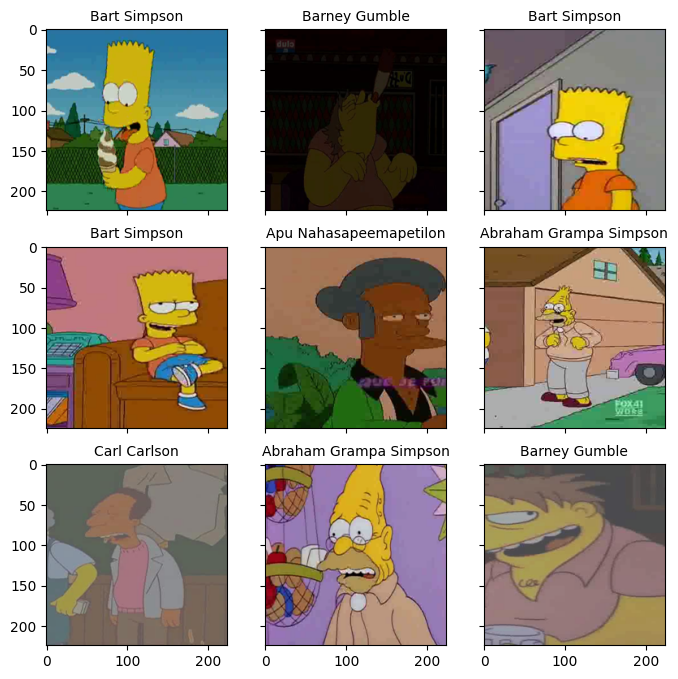

In [101]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [102]:
train_labels = [path.parent.name for path in train_files]

In [103]:
from collections import Counter
c = Counter(train_labels).most_common()[::-1]
c

[('lenny_leonard', 233),
 ('waylon_smithers', 238),
 ('ralph_wiggum', 268),
 ('nelson_muntz', 269),
 ('snake_jailbird', 287),
 ('rainier_wolfcastle', 289),
 ('martin_prince', 292),
 ('otto_mann', 294),
 ('groundskeeper_willie', 296),
 ('carl_carlson', 296),
 ('agnes_skinner', 296),
 ('miss_hoover', 296),
 ('patty_bouvier', 297),
 ('troy_mcclure', 298),
 ('cletus_spuckler', 298),
 ('disco_stu', 299),
 ('sideshow_mel', 300),
 ('lionel_hutz', 301),
 ('fat_tony', 305),
 ('gil', 305),
 ('professor_john_frink', 306),
 ('selma_bouvier', 308),
 ('maggie_simpson', 312),
 ('barney_gumble', 319),
 ('mayor_quimby', 323),
 ('edna_krabappel', 343),
 ('comic_book_guy', 352),
 ('kent_brockman', 373),
 ('apu_nahasapeemapetilon', 467),
 ('sideshow_bob', 658),
 ('abraham_grampa_simpson', 685),
 ('chief_wiggum', 739),
 ('milhouse_van_houten', 809),
 ('principal_skinner', 895),
 ('charles_montgomery_burns', 895),
 ('krusty_the_clown', 904),
 ('marge_simpson', 968),
 ('bart_simpson', 1006),
 ('lisa_simpson'

In [104]:
#making dataset more balansed
transform = transforms.Compose([
            transforms.ColorJitter(0.6, 0.6, 0.6, 0),
            transforms.RandomHorizontalFlip(),
        ])

In [105]:
char_lib = dict(c)
REQUIRED_SIZE = 400


for charecter_name in tqdm(np.array(c)[:,0]):
    paths = np.where(np.array(train_labels) == charecter_name)[0]

    num_added_imgs = 0
    num_augs_per_img = REQUIRED_SIZE // char_lib[charecter_name]

    for img_path in tqdm(paths):
        for i in range(num_augs_per_img):
            num_added_imgs += 1
            image = Image.open(train_files[img_path])
            image.load()

            new_image = transform(image)
            image_name = str(train_files[img_path])
            new_image_name = image_name[:-8] + str(i) + image_name[-7:]
            new_image.save(new_image_name)

            train_files.append(Path(new_image_name))
        if num_added_imgs >= REQUIRED_SIZE:
            break

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

  0%|          | 0/658 [00:00<?, ?it/s]

  0%|          | 0/685 [00:00<?, ?it/s]

  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/809 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/904 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/1006 [00:00<?, ?it/s]

  0%|          | 0/1015 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/1684 [00:00<?, ?it/s]

In [106]:
train_labels = [path.parent.name for path in train_files]

from collections import Counter
c = Counter(train_labels).most_common()[::-1]
c

[('lenny_leonard', 466),
 ('apu_nahasapeemapetilon', 467),
 ('waylon_smithers', 476),
 ('ralph_wiggum', 536),
 ('nelson_muntz', 538),
 ('snake_jailbird', 574),
 ('rainier_wolfcastle', 578),
 ('martin_prince', 584),
 ('otto_mann', 588),
 ('groundskeeper_willie', 592),
 ('carl_carlson', 592),
 ('agnes_skinner', 592),
 ('miss_hoover', 592),
 ('patty_bouvier', 594),
 ('troy_mcclure', 596),
 ('cletus_spuckler', 596),
 ('disco_stu', 598),
 ('sideshow_mel', 600),
 ('lionel_hutz', 602),
 ('fat_tony', 610),
 ('gil', 610),
 ('professor_john_frink', 612),
 ('selma_bouvier', 616),
 ('maggie_simpson', 624),
 ('barney_gumble', 638),
 ('mayor_quimby', 646),
 ('sideshow_bob', 658),
 ('abraham_grampa_simpson', 685),
 ('edna_krabappel', 686),
 ('comic_book_guy', 704),
 ('chief_wiggum', 739),
 ('kent_brockman', 746),
 ('milhouse_van_houten', 809),
 ('principal_skinner', 895),
 ('charles_montgomery_burns', 895),
 ('krusty_the_clown', 904),
 ('marge_simpson', 968),
 ('bart_simpson', 1006),
 ('lisa_simpson'

In [107]:
model = models.resnet152(weights='IMAGENET1K_V2')

In [108]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [109]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 60192808


In [110]:
# freezing first N blocks of parameters
N = 7

for (i, child) in enumerate(model.children()):
    # only for first N blocks
    if i < N:
        for param in child.parameters():
            param.requires_grad = False

In [111]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 17013736


In [112]:
# num_features -- the size of features vector that comes to the input of fc-layer
num_features = 2048
# replace the Fully-Connected layer with our linear classifier
model.fc = nn.Linear(num_features, 42)

model = model.cuda()


In [113]:
def fit_epoch(model, train_loader, criterion, optimizer):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    train_transform = transforms.Compose([
            transforms.ColorJitter(0.6, 0.6, 0.6, 0),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    for inputs, labels in tqdm(train_loader):
        # transformations with augmentations:
        inputs = inputs.float().permute(0,3,1,2).to(DEVICE)
        labels = labels.to(DEVICE)
        inputs = train_transform(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [114]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.float().to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [115]:
def train(train_files, val_files, model, epochs, batch_size,
          save_dir = './experiments/version_0/', prev_best_val_loss=None):

    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = torch.optim.AdamW(model.parameters(), lr= 0.0001)
        criterion = nn.CrossEntropyLoss()
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.03)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_loss < best_val_loss:
                best_val_loss = val_loss

                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': val_loss,
                            }, save_dir + 'best_checkpoint.pth') # change directory to one on google drive!!!

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            # scheduler.step()

    # save last state for trainig resuming
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                }, save_dir + 'last_checkpoint.pth')

    return history

In [116]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [117]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [118]:
history = train(train_dataset, val_dataset, model=model, epochs=6, batch_size=75, save_dir='./')

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

loss 1.1640660022584606

Epoch 001 train_loss: 1.1641     val_loss 0.2058 train_acc 0.7368 val_acc 0.9472


  0%|          | 0/396 [00:00<?, ?it/s]

loss 0.14655834975714818

Epoch 002 train_loss: 0.1466     val_loss 0.1464 train_acc 0.9643 val_acc 0.9627


  0%|          | 0/396 [00:00<?, ?it/s]

loss 0.07235913912269436

Epoch 003 train_loss: 0.0724     val_loss 0.1225 train_acc 0.9819 val_acc 0.9689


  0%|          | 0/396 [00:00<?, ?it/s]

loss 0.048376421633621304

Epoch 004 train_loss: 0.0484     val_loss 0.1048 train_acc 0.9875 val_acc 0.9748


  0%|          | 0/396 [00:00<?, ?it/s]

loss 0.037882124287930766

Epoch 005 train_loss: 0.0379     val_loss 0.1220 train_acc 0.9899 val_acc 0.9706


  0%|          | 0/396 [00:00<?, ?it/s]

loss 0.0324130101692982

Epoch 006 train_loss: 0.0324     val_loss 0.1311 train_acc 0.9915 val_acc 0.9696


In [119]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

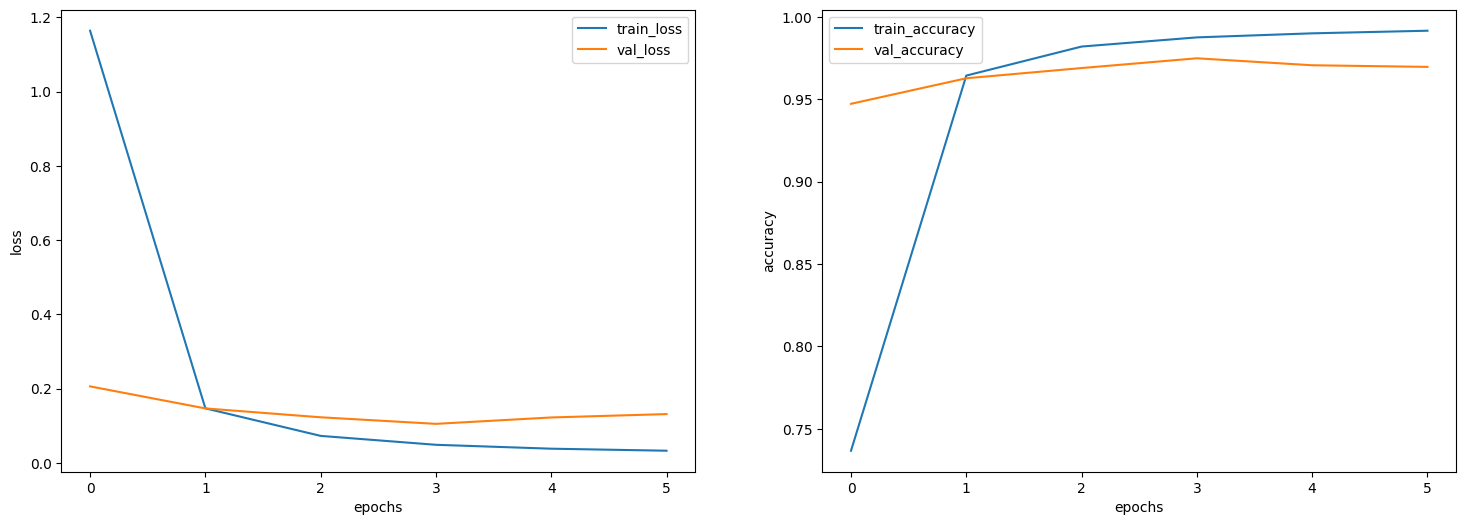

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(train_loss, label="train_loss")
ax[0].plot(val_loss, label="val_loss")
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")

ax[1].plot(train_acc, label="train_accuracy")
ax[1].plot(val_acc, label="val_accuracy")
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
plt.show()

In [121]:
save_dir = '/content/best_checkpoint.pth'
checkpoint = torch.load(save_dir)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [122]:
def predict_one_sample(model, inputs, device=DEVICE):
    #prediction for one picture
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

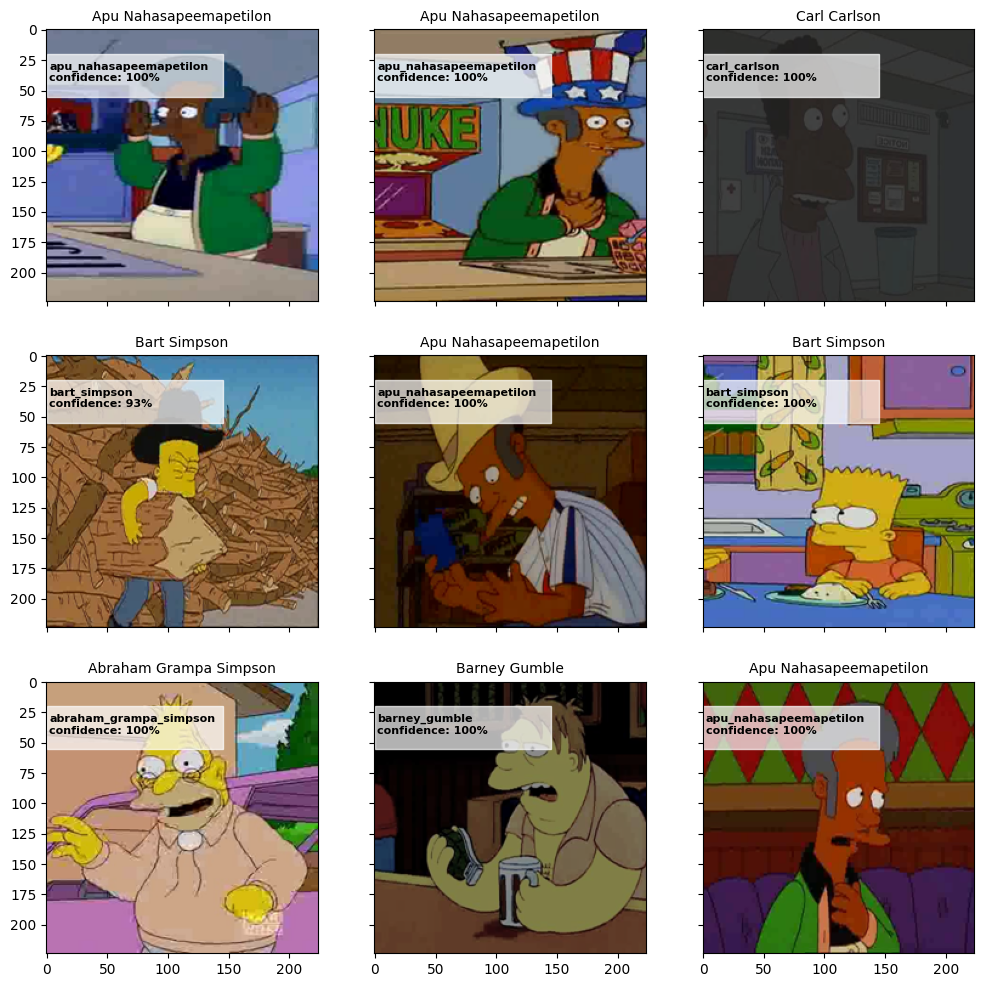

In [127]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 20), 145, 35, color='white', alpha=0.7))
    font0 = FontProperties()
    font = font0.copy()
    # font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{}\nconfidence: {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(2, 26, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')